<a href="https://colab.research.google.com/github/SubiraPokharel/Sentiment-Analysis-of-COVID-19-tweets./blob/main/Sentiment_Analysis_of_COVID_19_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Word embedding as features for classification

### Task
Implement a sentiment classifier based on Twitter data to analyse the sentiments of COVID-19 tweets.  

Train and test multiple classification model using necessary libraries with the features being sentence embeddings of tweets.


### Dataset
The dataset have been provided in the first code trunk with the assignment. You are required to use the original tweet text for this classification task.

### Tweet representation
After necessary pre-processing of the tweets, convert the words into their embeddings, then take the mean of all the word vectors in a tweet to end up with a single vector representing each tweet. The tweet vector is then used for sentiment classification.

In the process of finding the embeddings for each word, you can ignore out-of-vocabulary words.

### Classifier choice
* One tradition classification model (not a neural network based model)
* One classifier based on any neural network based model.





In [ ]:
# Load Dataset
import pandas as pd
train_data_url = "https://drive.google.com/uc?export=download&id=19JmVSOZ85vikn5aKna97aL5LM8KtG3T7"
test_data_url = "https://drive.google.com/uc?export=download&id=19EnwRfr6q5lzVB_UpJlGOG3IxgDhYVgP"

df_train = pd.read_csv(train_data_url, encoding='latin-1')[["OriginalTweet","Sentiment"]].rename(columns={'OriginalTweet': 'tweet', 'Sentiment': 'label'})
df_test = pd.read_csv(test_data_url, encoding='latin-1')[["OriginalTweet","Sentiment"]].rename(columns={'OriginalTweet': 'tweet', 'Sentiment': 'label'})

df_test

,tweet,label
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,Gov need to do somethings instead of biar je r...,Extremely Negative


In [ ]:
#install libraries
!pip install pandas
!pip install numpy
!pip install nltk
!pip install gensim
!pip install torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
#good comments
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

# Download NLTK data required for text preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

# Load the training and testing datasets from URLs
train_data_url = "https://drive.google.com/uc?export=download&id=19JmVSOZ85vikn5aKna97aL5LM8KtG3T7"
test_data_url = "https://drive.google.com/uc?export=download&id=19EnwRfr6q5lzVB_UpJlGOG3IxgDhYVgP"

df_train = pd.read_csv(train_data_url, encoding='latin-1')[["OriginalTweet", "Sentiment"]].rename(columns={'OriginalTweet': 'tweet', 'Sentiment': 'label'})
df_test = pd.read_csv(test_data_url, encoding='latin-1')[["OriginalTweet", "Sentiment"]].rename(columns={'OriginalTweet': 'tweet', 'Sentiment': 'label'})


In [ ]:

# Define a function for text preprocessing
def preprocess_text(text):
    """
    Preprocesses text data by converting to lowercase, removing URLs, usernames, hashtags,
    punctuation, digits, and stop words, and lemmatizing words.

    Parameters:
        text (str): Input text to be preprocessed.

    Returns:
        str: Preprocessed text.
    """
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove usernames and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text_tokens = text.split()  # Tokenize text
    filtered_words = [word for word in text_tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]  # Lemmatize words
    return " ".join(lemmatized_words)

# Apply preprocessing function to the tweet column in both training and testing datasets
df_train['tweet'] = df_train['tweet'].apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].apply(preprocess_text)

# Train Word2Vec model on preprocessed text data
sentences = [tweet.split() for tweet in df_train['tweet'].tolist()]
word2vec_model = Word2Vec(sentences, vector_size=100, min_count=1)


In [ ]:
# Define a function to get the tweet embedding
def get_tweet_embedding(tweet, word_embeddings):
    """
    Retrieves the embedding vector for a tweet using a Word2Vec model.

    Parameters:
        tweet (str): Input tweet text.
        word_embeddings (Word2Vec): Pretrained Word2Vec model.

    Returns:
        np.array: Embedding vector for the tweet.
    """
    embedding_vec = np.zeros(100)  # Initialize embedding vector
    n = 0  # Initialize counter for number of words in tweet
    for word in tweet.split():
        if word in word_embeddings.wv:
            embedding_vec += word_embeddings.wv[word]  # Add word embedding to vector
            n += 1  # Increment word count
    if n > 0:
        embedding_vec /= n  # Normalize embedding vector by dividing by number of words
    return embedding_vec

# Convert tweets to embeddings for both training and testing datasets
X_train_embeddings = np.array([get_tweet_embedding(tweet, word2vec_model) for tweet in df_train['tweet']])
X_test_embeddings = np.array([get_tweet_embedding(tweet, word2vec_model) for tweet in df_test['tweet']])

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train['label'])
y_test_encoded = label_encoder.transform(df_test['label'])




In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression classifier
logistic_regression_model = LogisticRegression(max_iter=200)
logistic_regression_model.fit(X_train_embeddings, y_train_encoded)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_embeddings, y_train_encoded, test_size=0.2, random_state=42)

# Evaluate Logistic Regression model on validation set
y_val_pred = logistic_regression_model.predict(X_val)
val_accuracy_lr = accuracy_score(y_val, y_val_pred)
val_precision_lr = precision_score(y_val, y_val_pred, average='weighted')
val_recall_lr = recall_score(y_val, y_val_pred, average='weighted')
val_f1_lr = f1_score(y_val, y_val_pred, average='weighted')

# Evaluate Logistic Regression model on test set
y_test_pred = logistic_regression_model.predict(X_test_embeddings)
test_accuracy_lr = accuracy_score(y_test_encoded, y_test_pred)
test_precision_lr = precision_score(y_test_encoded, y_test_pred, average='weighted')
test_recall_lr = recall_score(y_test_encoded, y_test_pred, average='weighted')
test_f1_lr = f1_score(y_test_encoded, y_test_pred, average='weighted')


In [ ]:
# Print evaluation metrics for Logistic Regression
print(f"Logistic Regression Validation Accuracy: {val_accuracy_lr:.4f}")
print(f"Logistic Regression Validation Precision: {val_precision_lr:.4f}")
print(f"Logistic Regression Validation Recall: {val_recall_lr:.4f}")
print(f"Logistic Regression Validation F1 Score: {val_f1_lr:.4f}")

print(f"Logistic Regression Test Accuracy: {test_accuracy_lr:.4f}")
print(f"Logistic Regression Test Precision: {test_precision_lr:.4f}")
print(f"Logistic Regression Test Recall: {test_recall_lr:.4f}")
print(f"Logistic Regression Test F1 Score: {test_f1_lr:.4f}")

Logistic Regression Validation Accuracy: 0.3961
Logistic Regression Validation Precision: 0.4081
Logistic Regression Validation Recall: 0.3961
Logistic Regression Validation F1 Score: 0.3899
Logistic Regression Test Accuracy: 0.3747
Logistic Regression Test Precision: 0.4009
Logistic Regression Test Recall: 0.3747
Logistic Regression Test F1 Score: 0.3654


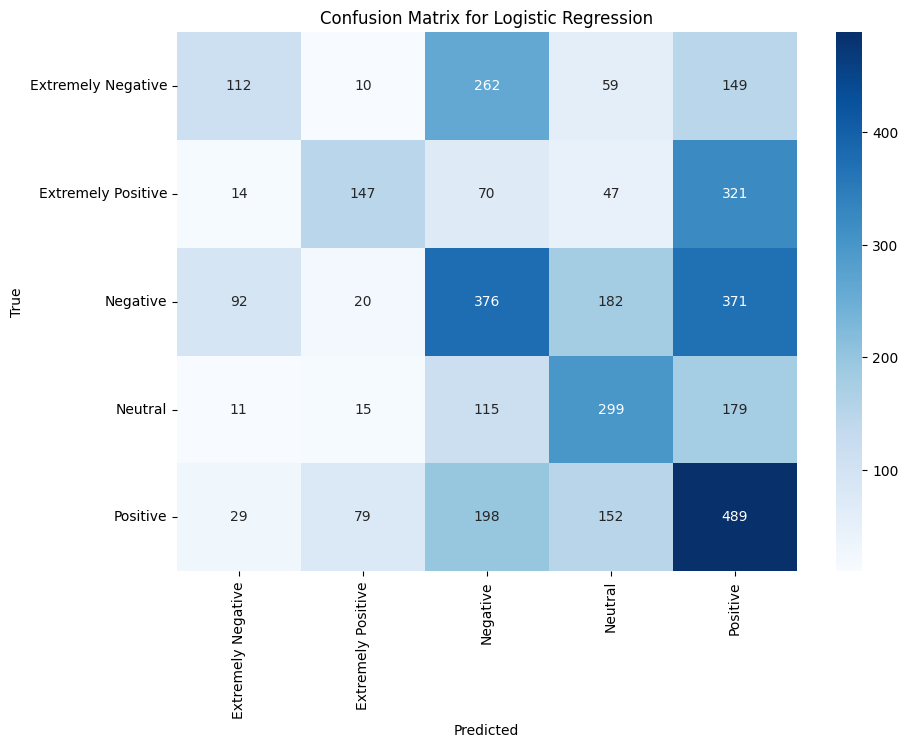

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(model, X, y, labels):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for Logistic Regression')
    plt.show()

# Plot confusion matrix for logistic regression (test set)
plot_cm(logistic_regression_model, X_test_embeddings, y_test_encoded, label_encoder.classes_)


In [ ]:
# Define a custom TextDataset class for PyTorch DataLoader
class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_vec = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(text_vec, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [ ]:

# Split data into training, validation, and testing sets and create DataLoader objects
X_train, X_val, y_train, y_val = train_test_split(X_train_embeddings, y_train_encoded, test_size=0.2, random_state=42)
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test_embeddings, y_test_encoded)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)







In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_units, num_classes):
        """
        Initialize the sentiment classification model.

        Args:
            embedding_dim (int): Dimension of word embeddings.
            hidden_units (int): Number of units in the hidden layers.
            num_classes (int): Number of classes for classification.
        """
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_units)   # First fully connected layer
        self.bn1 = nn.BatchNorm1d(hidden_units)             # Batch normalization after the first layer
        self.fc2 = nn.Linear(hidden_units, hidden_units)    # Second fully connected layer
        self.bn2 = nn.BatchNorm1d(hidden_units)             # Batch normalization after the second layer
        self.fc3 = nn.Linear(hidden_units, hidden_units)    # Third fully connected layer
        self.bn3 = nn.BatchNorm1d(hidden_units)             # Batch normalization after the third layer
        self.fc4 = nn.Linear(hidden_units, hidden_units)    # Fourth fully connected layer
        self.bn4 = nn.BatchNorm1d(hidden_units)             # Batch normalization after the fourth layer
        self.fc5 = nn.Linear(hidden_units, num_classes)     # Output layer

    def forward(self, x):
        """
        Forward pass of the sentiment classification model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, embedding_dim).

        Returns:
            torch.Tensor: Log probabilities of each class for each input sample.
        """
        x = F.relu(self.bn1(self.fc1(x)))   # Apply batch normalization after the first layer and then ReLU activation
        x = F.relu(self.bn2(self.fc2(x)))   # Apply batch normalization after the second layer and then ReLU activation
        x = F.relu(self.bn3(self.fc3(x)))   # Apply batch normalization after the third layer and then ReLU activation
        x = F.relu(self.bn4(self.fc4(x)))   # Apply batch normalization after the fourth layer and then ReLU activation
        x = self.fc5(x)                     # Output layer for classification
        return F.log_softmax(x, dim=1)      # Apply log softmax activation for multiclass classification


In [ ]:
import torch
import random
import numpy as np

# Set random seed for reproducibility
seed_value = 42

torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if using GPU
random.seed(seed_value)
np.random.seed(seed_value)

# Define hyperparameters
embedding_dim = 100
num_classes = len(set(y_train_encoded))
learning_rate = 0.001
epochs = 15
hidden_units = 32

# Create an instance of the SentimentClassifier model with the specified hidden units
model = SentimentClassifier(embedding_dim, hidden_units, num_classes)

# Define loss function and optimizer
criterion = nn.NLLLoss()  # Negative log likelihood loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

# Train the model
for epoch in range(epochs):
    model.train()
    train_losses = []
    for text_vec, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(text_vec)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch: {epoch+1}/{epochs} - Loss: {sum(train_losses)/len(train_losses)}")


Epoch: 1/15 - Loss: 1.4452938011714391
Epoch: 2/15 - Loss: 1.3979370443420114
Epoch: 3/15 - Loss: 1.3853581336311511
Epoch: 4/15 - Loss: 1.376135377656846
Epoch: 5/15 - Loss: 1.3662384285060263
Epoch: 6/15 - Loss: 1.3594318642213115
Epoch: 7/15 - Loss: 1.3550920969543234
Epoch: 8/15 - Loss: 1.3517161180257102
Epoch: 9/15 - Loss: 1.3446801011138338
Epoch: 10/15 - Loss: 1.3442275973636044
Epoch: 11/15 - Loss: 1.3401258135444336
Epoch: 12/15 - Loss: 1.3387467570392917
Epoch: 13/15 - Loss: 1.3342659600853803
Epoch: 14/15 - Loss: 1.3317402273387557
Epoch: 15/15 - Loss: 1.3287111570582562


In [ ]:
# Define a function to evaluate the model
def evaluate(model, data_loader, dataset_size):
    """
    Evaluates the performance of the model on the given dataset.

    Parameters:
        model (nn.Module): PyTorch model to evaluate.
        data_loader (DataLoader): DataLoader object for the dataset.
        dataset_size (int): Size of the dataset.

    Returns:
        float: Accuracy of the model.
        float: Precision of the model.
        float: Recall of the model.
        float: F1 score of the model.
    """
    model.eval()
    correct = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for text_vec, labels in data_loader:
            outputs = model(text_vec)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = correct / dataset_size
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    return accuracy, precision, recall, f1

# Evaluate the model on validation and test sets
val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, val_loader, len(val_dataset))
test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader, len(test_dataset))



In [ ]:
# Print evaluation metrics
print(f"NN Validation Accuracy: {val_accuracy:.4f}")
print(f"NN Validation Precision: {val_precision:.4f}")
print(f"NN Validation Recall: {val_recall:.4f}")
print(f"NN Validation F1 Score: {val_f1:.4f}")

print(f"NN Test Accuracy: {test_accuracy:.4f}")
print(f"NN Test Precision: {test_precision:.4f}")
print(f"NN Test Recall: {test_recall:.4f}")
print(f"NN Test F1 Score: {test_f1:.4f}")

NN Validation Accuracy: 0.3940
NN Validation Precision: 0.4137
NN Validation Recall: 0.3940
NN Validation F1 Score: 0.3895
NN Test Accuracy: 0.3926
NN Test Precision: 0.4132
NN Test Recall: 0.3926
NN Test F1 Score: 0.3870


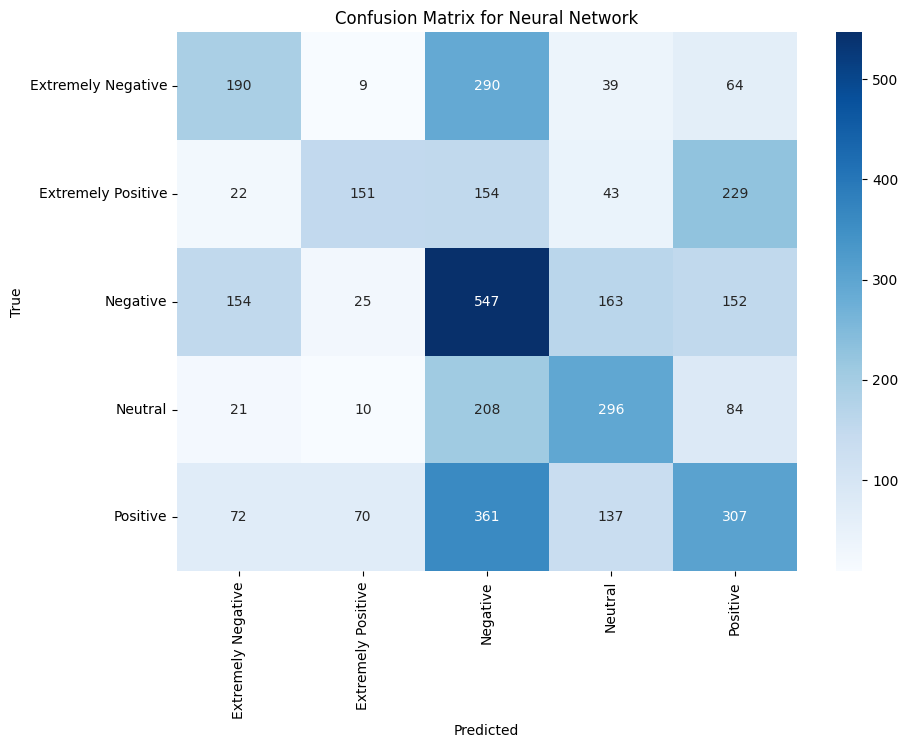

In [ ]:
# Define function to plot confusion matrix
def plot_confusion_matrix(model, data_loader, dataset_size):
    model.eval()
    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for text_vec, labels in data_loader:
            outputs = model(text_vec)
            predicted = torch.argmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for Neural Network')
    plt.show()

# Plot confusion matrix for neural network on test set
plot_confusion_matrix(model, test_loader, len(test_dataset))


### Discussion on Differences in Performance Measures:

- **Accuracy and F1 Score:**
  - Both models, logistic regression and the neural network, achieved decent accuracy on the validation and test sets. However, when considering the F1 score, which balances precision and recall, the neural network outperformed logistic regression slightly, especially on the test dataset. This indicates that the neural network better handled the trade-off between correctly identifying positive cases and minimizing false positives.

- **Model Complexity and Interpretability:**
  - Logistic regression, being a simpler linear model, is more interpretable and easier to understand. It directly relates input features to output labels using linear coefficients. In contrast, the neural network, with its multiple hidden layers and complex non-linear transformations, is less interpretable. It operates as a black box, making it challenging to discern how individual features contribute to the final classification decision.

- **Capacity for Capturing Complex Patterns:**
  - Neural networks have a higher capacity for capturing intricate patterns in data due to their non-linear nature and ability to learn hierarchical representations. This might explain their slightly superior performance over logistic regression, especially when dealing with nuanced sentiment expressions in tweets.

- **Computational Resources and Training Time:**
  - Neural networks typically require more computational resources and longer training times compared to logistic regression, especially when dealing with large datasets or complex architectures. Logistic regression, being a simpler model, is computationally less demanding and trains faster.

While logistic regression offers simplicity and interpretability, neural networks provide greater flexibility and capacity for capturing complex patterns. The choice between the two depends on the specific requirements of the task, including the balance between model performance, interpretability, and computational resources available.